---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

> In this notebook, we take a look at some of the derived quantities for sea surface height (SSH). These are physically meaningful quantities like velocity and vorticity. From these, we can visually assess how well our reconstruction methods perform.

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
from dataclasses import dataclass, field
from typing import List, Dict

@dataclass
class Subset:
    _target_: str = "builtins.slice"
    _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-01"])


@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.40
    decode_times: bool = False
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["ssh"])
    paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013*"
    
    

# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [6]:
select = {"time": slice("2013-01-01", "2013-02-01")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms
)

dm.setup()



init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


(-0.8937392813409808, 0.8845801024344544, (32, 3), -1.0, 1.0, (32, 1))

In [7]:
xrda = dm.load_xrds()
xrda

<xarray.Dataset>
Dimensions:  (time: 32, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-02-01
Data variables:
    ssh      (time, lat, lon) float64 0.5287 0.5287 0.523 ... -0.1756 -0.1756

In [8]:
import jejeqx._src.transforms.xarray.geostrophic as geocalc
import jejeqx._src.viz.geostrophic as geoplot
from jejeqx._src.viz.utils import get_cbar_label

## Sea Surface Height

$$
\begin{aligned}
\text{Sea Surface Height}[m]: && 
\eta &=\boldsymbol{\eta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\eta}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

In [9]:
ds = geocalc.get_ssh_dataset(xrda.ssh)

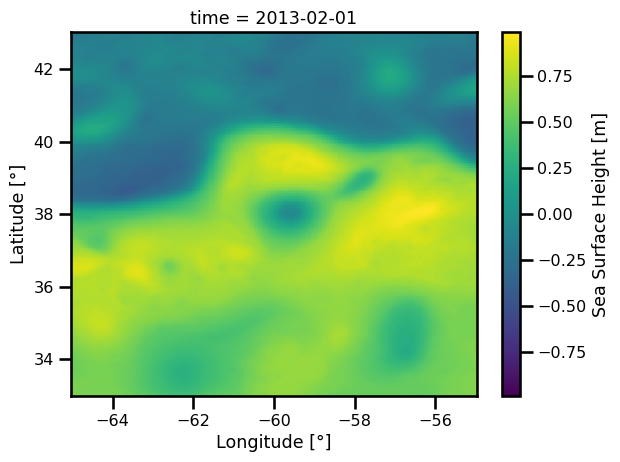

In [10]:
cbar_kwargs = {"label": get_cbar_label(ds.ssh)}

_ = geoplot.plot_colormap(
    ds.ssh.isel(time=-1), cmap="viridis",
    cbar_kwargs=cbar_kwargs,
)

## Stream Function

$$
\begin{aligned}
\text{Stream Function }[ms^{-1}]: && 
\psi &=\boldsymbol{\psi}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\psi = \frac{g}{f_0}\eta
$$

In [11]:
ds = geocalc.calculate_streamfunction(ds, "ssh")

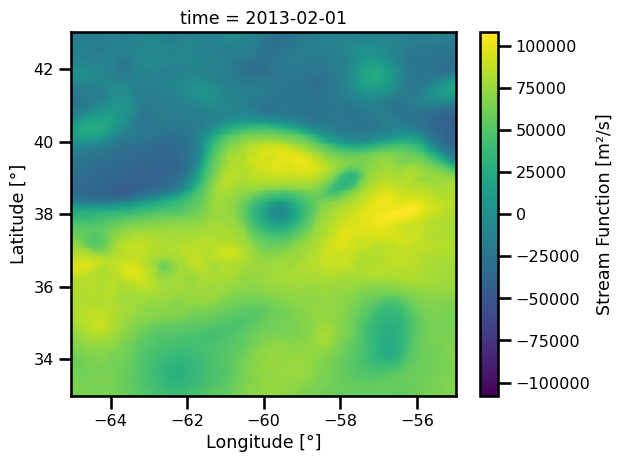

In [12]:
cbar_kwargs = {"label": get_cbar_label(ds.psi)}

_ = geoplot.plot_colormap(
    ds.psi.isel(time=-1), cmap="viridis",
    cbar_kwargs=cbar_kwargs,
)

## Velocities

In [13]:
ds = geocalc.calculate_velocities_sf(ds, "psi")

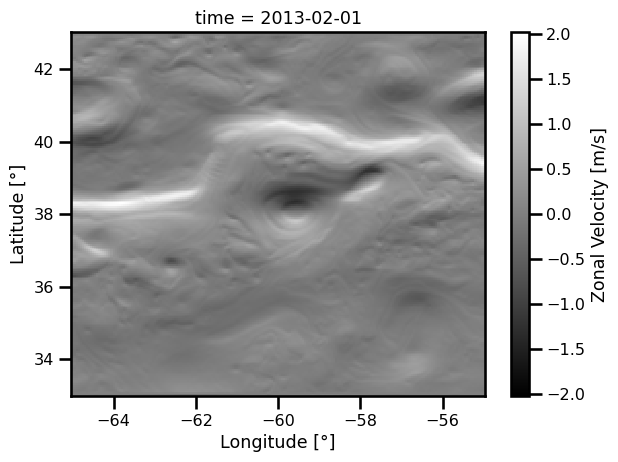

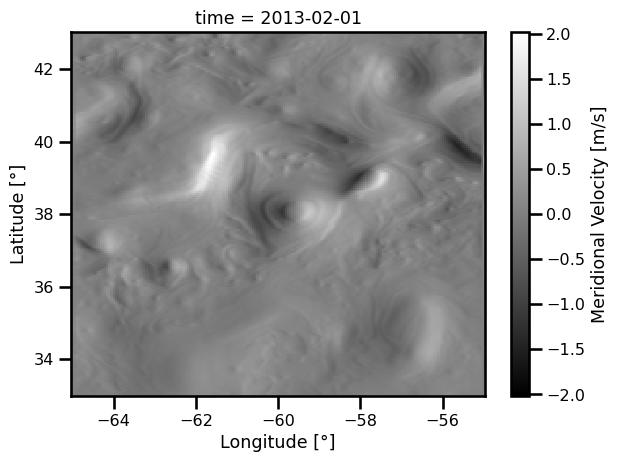

In [14]:
cbar_kwargs = {"label": get_cbar_label(ds.u)}

_ = geoplot.plot_colormap(
    ds.u.isel(time=-1), cmap="gray",
    cbar_kwargs=cbar_kwargs,
)

cbar_kwargs = {"label": get_cbar_label(ds.v)}

_ = geoplot.plot_colormap(
    ds.v.isel(time=-1), cmap="gray",
    cbar_kwargs=cbar_kwargs,
)

## Kinetic Energy

$$
\begin{aligned}
E &= \frac{1}{2}\int \mathbf{u}^2dr \\
E &\approx \frac{1}{2} \mathbb{E}\left[ \mathbf{u}^2\right] \\
&= \frac{1}{2} \mathbb{E}\left[ u^2 + v^2\right]
\end{aligned}
$$

In [15]:
ds = geocalc.calculate_kinetic_energy(ds, ["u","v"])

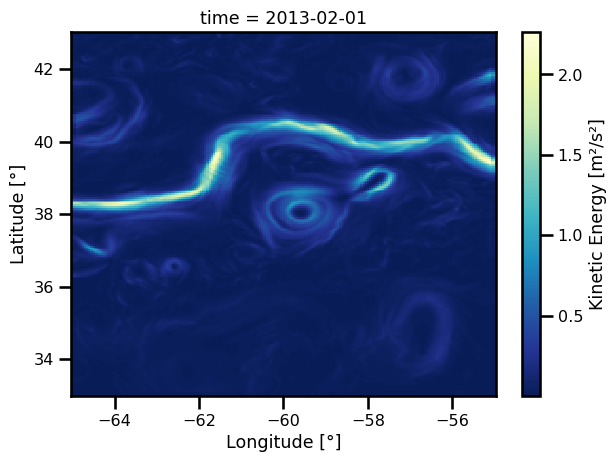

In [16]:
cbar_kwargs = {"label": get_cbar_label(ds.ke)}

_ = geoplot.plot_colormap(
    ds.ke.isel(time=-1), cmap="YlGnBu_r",
    cbar_kwargs=cbar_kwargs,
)


## Relative Vorticity

Somtimes called the *vertical vorticity*.



$$
\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$

Note that the u,v velocities can be calculated from the stream function as

$$
\begin{aligned}
u &= -\frac{\partial \psi}{\partial y} && &&
v = \frac{\partial \psi}{\partial x}\\
\end{aligned}
$$

So plugging these into the equation, we get:

$$
\begin{aligned}
\zeta &= 
\frac{\partial}{\partial x}\left(\frac{\partial \psi}{\partial x}\right) - 
\frac{\partial}{\partial y}\left( -\frac{\partial \psi}{\partial y}\right) \\
\zeta &= 
\frac{\partial^2 \psi}{\partial x^2}+ \frac{\partial^2 \psi}{\partial y^2}\\
\zeta &=\nabla^2\psi
\end{aligned}
$$

We can also calculate a normalized version

$$
\bar{\zeta} = \frac{\zeta}{f_0}
$$

Note: This is closely related to the geostrophic eqns:

$$
\begin{aligned}
\text{Relative Vorticity }[s^{-1}]: && 
\zeta &=\boldsymbol{\zeta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\xi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\zeta = \nabla^2\psi
$$


In [17]:
ds = geocalc.calculate_relative_vorticity_uv(ds, ["u","v"], normalized=True)

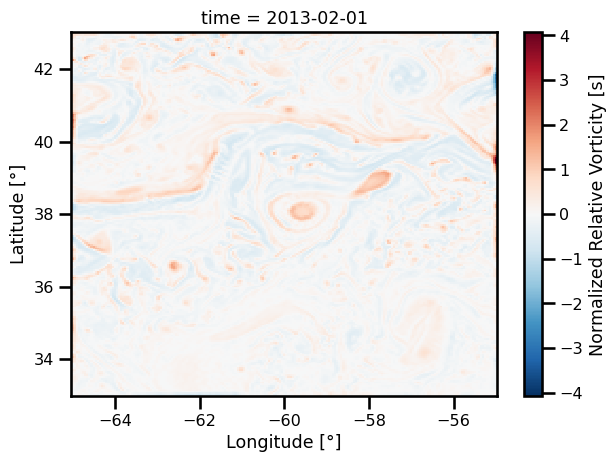

In [18]:
cbar_kwargs = {"label": get_cbar_label(ds.vort_r)}

_ = geoplot.plot_colormap(
    ds.vort_r.isel(time=-1), cmap="RdBu_r",
    cbar_kwargs=cbar_kwargs,
)

## Absolute Vorticity

Somtimes called the *horizontal divergence*.



$$
\zeta = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

Note that the u,v velocities can be calculated from the stream function as

$$
\begin{aligned}
u &= -\frac{\partial \psi}{\partial y} && &&
v = \frac{\partial \psi}{\partial x}\\
\end{aligned}
$$

So plugging these into the equation, we get:

$$
\begin{aligned}
\zeta &= 
\frac{\partial}{\partial x}\left(\frac{\partial \psi}{\partial x}\right) + 
\frac{\partial}{\partial y}\left( -\frac{\partial \psi}{\partial y}\right) \\
\zeta &= 
\frac{\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}
\end{aligned}
$$

We can also calculate a normalized version

$$
\bar{\zeta} = \frac{\zeta}{f_0}
$$

In [19]:

ds = geocalc.calculate_absolute_vorticity_uv(ds, ["u","v"], normalized=True)

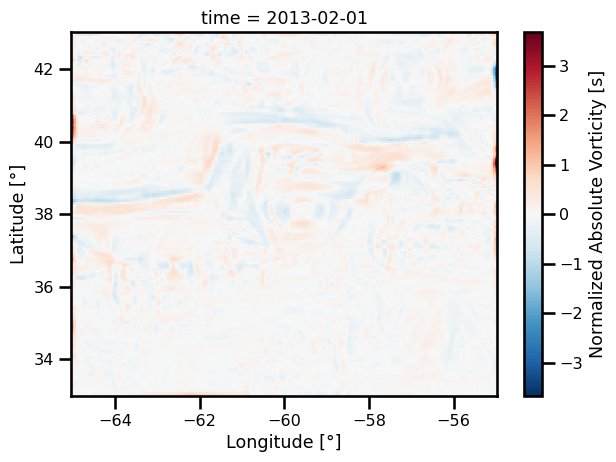

In [20]:
cbar_kwargs = {"label": get_cbar_label(ds.vort_a)}

_ = geoplot.plot_colormap(
    ds.vort_a.isel(time=-1), cmap="RdBu_r",
    cbar_kwargs=cbar_kwargs,
)

## Enstropy

This is a summarization of the relative vorticity

$$
\begin{aligned}
Z &= \frac{1}{2}\int \zeta^2 dr \\
Z &\approx \frac{1}{2} \mathbb{E}\left[ \zeta^2 \right] \\
\end{aligned}
$$

In [21]:
ds = geocalc.calculate_relative_vorticity_uv(ds, ["u","v"], normalized=False)
ds = geocalc.calculate_enstropy(ds, "vort_r")

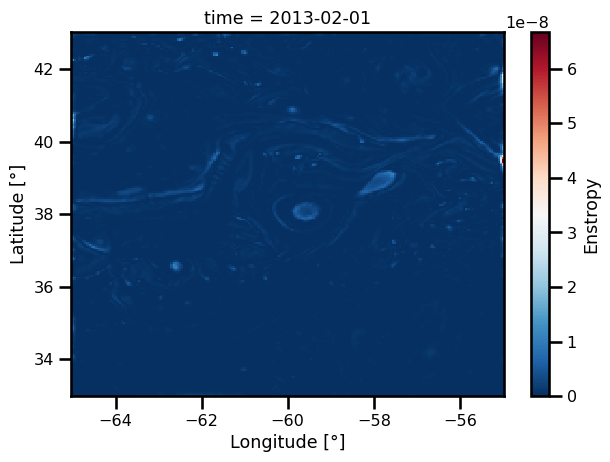

In [22]:
cbar_kwargs = {"label": get_cbar_label(ds.ens)}

_ = geoplot.plot_colormap(
    ds.ens.isel(time=-1), cmap="RdBu_r",
    cbar_kwargs=cbar_kwargs,
)

## Strain 

We have the normal strain


$$
\sigma_n = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}
$$

We also have the shear strain given by:

$$
\sigma_s = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

Often, we are interested in the strain magnitude give by:

$$
\sigma = \sqrt{\sigma_n^2 + \sigma_s^2}
$$

The normal and shear strains are coordinate invariant.
The vorticity and divergence and strain magnitude is coordinate invariant!

Often times, we use the relative strain magnitude:

$$
\bar{\sigma} = \frac{\sigma}{f_0}
$$

In [24]:
ds = geocalc.calculate_strain_magnitude(ds, ["u","v"], normalized=True)


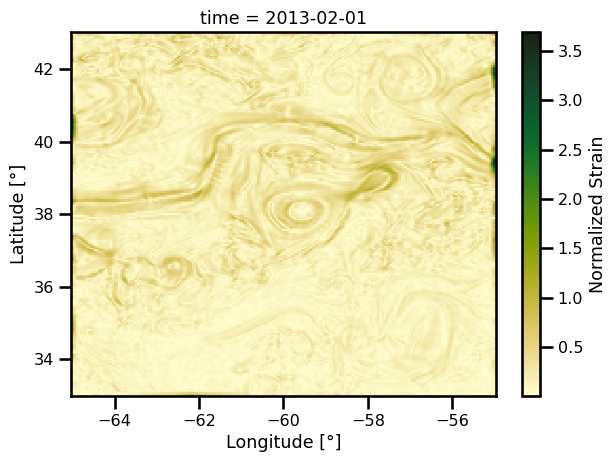

In [25]:
import cmocean as cmo
cbar_kwargs = {"label": get_cbar_label(ds.strain)}

_ = geoplot.plot_colormap(
    ds.strain.isel(time=-1), cmap=cmo.cm.speed, robust=False,#cmap="cmo.thermal",
    cbar_kwargs=cbar_kwargs,
)

## Okubo-Weiss Parameter

> OW parameter [Okubo, 1970; Weiss, 1991] describes the relative dominance of deformation with respect to rotation of the flow.

This is a combination of the Strain (deformation rate) and the vorticity

$$
\sigma_o = \sigma_n^2 + \sigma_s^2 - \zeta^2
$$

where:

$$
\begin{aligned}
\text{Normal Strain}: && &&
\sigma_n &= \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} \\
\text{Shear Strain}: && &&
\sigma_s &= \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \\
\text{Relative Vorticity}: && &&
\zeta &= \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{aligned}
$$

**Sources**:

* [Wiki](https://en.wikipedia.org/wiki/Okubo%E2%80%93Weiss_parameter)
* [Paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrc.20318)

In [32]:
ds = geocalc.calculate_okubo_weiss(ds, ["u","v"], normalized=True)


In [42]:
ow_std = np.std(ds.ow)
ow_threshhold = 0.2 * ow_std

In [48]:
levels = [-ow_threshhold.data.magnitude, ow_threshhold.data.magnitude]
levels, ds.ow.min(), ds.ow.max()

([-3.3754178716313725e-06, 3.3754178716313725e-06],
 <xarray.DataArray 'ow' ()>
 <Quantity(-0.00136693415, '1 / second')>,
 <xarray.DataArray 'ow' ()>
 <Quantity(0.00110746108, '1 / second')>)

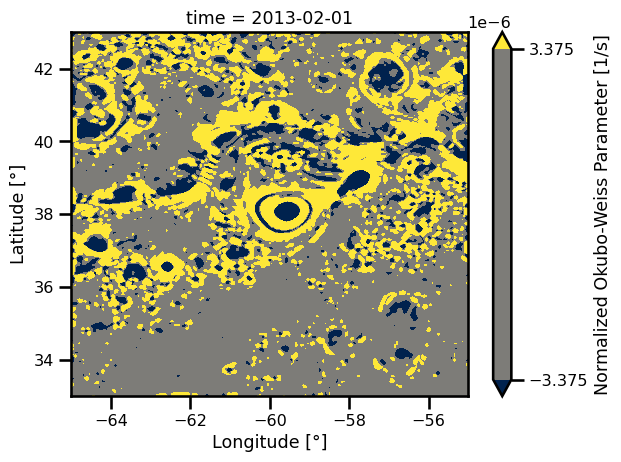

In [60]:
import cmocean as cmo
cbar_kwargs = {"label": get_cbar_label(ds.ow)}

fig, ax = plt.subplots()

ds.ow.isel(time=-1).plot.contourf(
    ax=ax, cmap="cividis", levels=levels, cbar_kwargs=cbar_kwargs
)

plt.tight_layout()
plt.show()